In [1]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import torch
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time

### Load data

In [56]:
!wget --random-wait -i data/georges.csv -P data/images/georges
!wget --random-wait -i data/non_georges.csv -P data/images/non_georges

#### Visualize a few images

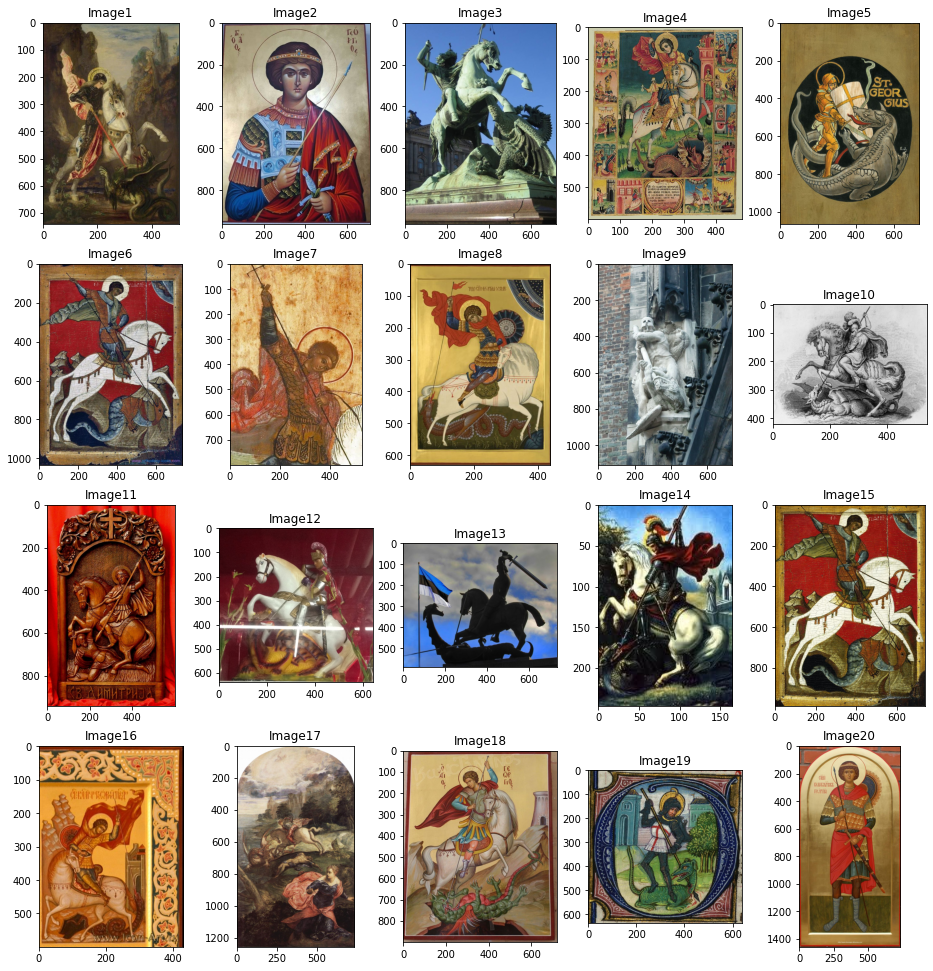

In [3]:
fig = plt.figure(figsize=(16, 17))
axes = []
path = 'data/images/georges'
for i, img_name in zip(np.arange(1, 21), os.listdir(path)[:20]):
    axes.append(fig.add_subplot(4, 5, i))
    subplot_title = ("Image" + str(i))
    axes[-1].set_title(subplot_title) 
    img_path = os.path.join(path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

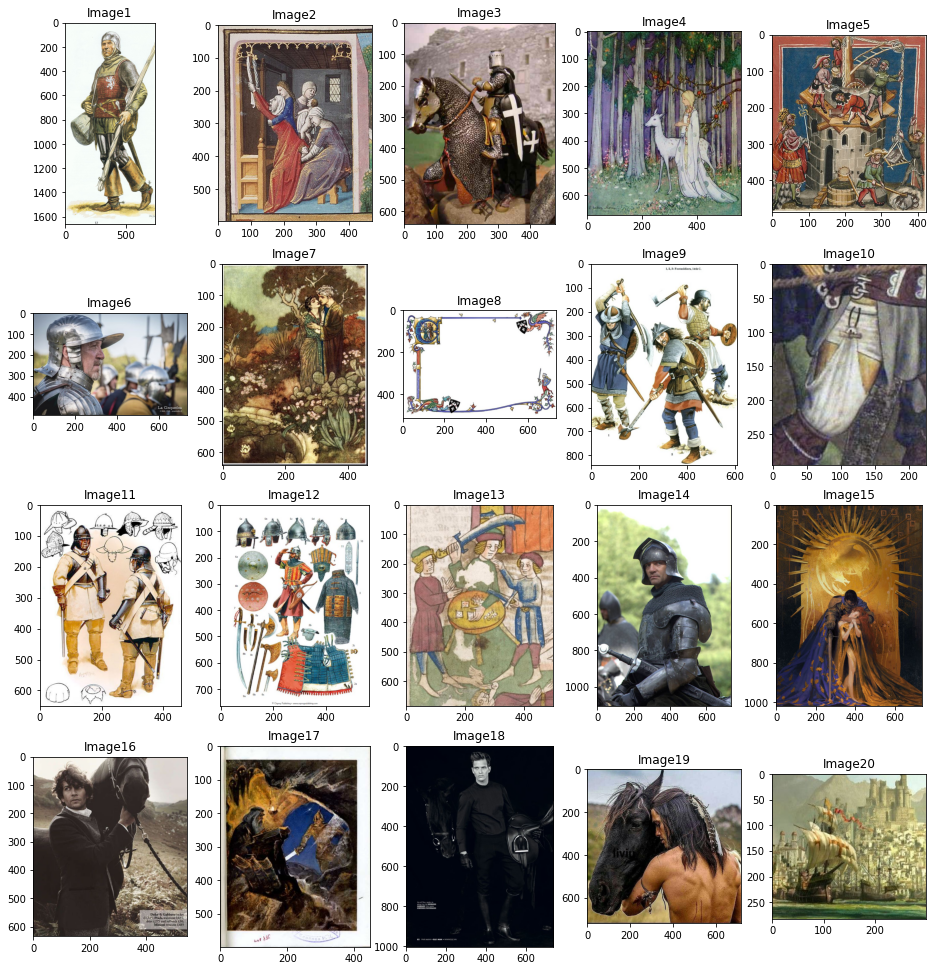

In [4]:
fig = plt.figure(figsize=(16, 17))
axes = []
path = 'data/images/non_georges'
for i, img_name in zip(np.arange(1, 21), os.listdir(path)[:20]):
    axes.append(fig.add_subplot(4, 5, i))
    subplot_title = ("Image" + str(i))
    axes[-1].set_title(subplot_title) 
    img_path = os.path.join(path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

### Define parameters

In [55]:
train_size = 0.7
feature_extract = True
num_classes = 2
input_size = 224 # Resnet50
num_workers = 4
batch_size = 64
lr = 0.001
momentum = 0.9
criterion = nn.CrossEntropyLoss()
num_epochs = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [48]:
np.random.seed(12)
torch.manual_seed(12)
torch.set_deterministic(True)

### Define and initialize model

In [49]:
model = models.resnet50(pretrained=True)

if feature_extract:
    for param in model.parameters():
        param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

### Setup transforms, datasets, and dataloaders

In [50]:
dataset = datasets.ImageFolder('data/images')

num_imgs = len(dataset)
indices = list(range(num_imgs))
class_names = dataset.classes

split = int(train_size * num_imgs)
np.random.shuffle(indices)
train_idx, val_idx= indices[:split], indices[split:]

train_data = Subset(dataset, indices=train_idx)
val_data = Subset(dataset, indices=val_idx)

train_data.dataset = copy.deepcopy(dataset)
val_data.dataset = copy.deepcopy(dataset)

train_trans = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_trans = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data.dataset.transform = train_trans
val_data.dataset.transform = val_trans

dataloaders_dict = {'train' : DataLoader(train_data, batch_size=batch_size,
                                         num_workers=num_workers, shuffle=True),
                    'val' : DataLoader(val_data, batch_size=batch_size, 
                                       num_workers=num_workers, shuffle=True)
                   }

### Create the optimizer

In [51]:
params_to_update = model.parameters()
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)

optimizer = optim.SGD(params_to_update, lr=lr, momentum=momentum)

### Train and evaluate

In [52]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [53]:
def visualize_model(model, num_images=6):
    mean = np.array([0.485, 0.456, 0.406])
    std =  np.array([0.229, 0.224, 0.225])
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(16, 17))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_dict['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}, true label: {class_names[labels[j]]}')
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0)) * std + mean
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [54]:
model, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/2
----------


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/gorogorov/.cache/pypoetry/virtualenvs/transfer-learning-demo-X-9nS9pW-py3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3427, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-54-bcf832ac62ef>", line 1, in <module>
    model, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)
  File "<ipython-input-52-fbaa1574495b>", line 29, in train_model
    outputs = model(inputs)
  File "/home/gorogorov/.cache/pypoetry/virtualenvs/transfer-learning-demo-X-9nS9pW-py3.9/lib/python3.9/site-packages/torch/nn/modules/module.py", line 727, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/gorogorov/.cache/pypoetry/virtualenvs/transfer-learning-demo-X-9nS9pW-py3.9/lib/python3.9/site-packages/torchvision/models/resnet.py", line 220, in forward
    return self._forward_impl(x)
  File "/home/gorogorov/.cache/pypoetry/virtualenvs/transfer-

TypeError: object of type 'NoneType' has no len()

In [ ]:
visualize_model(model, 12)

In [ ]:
torch.save(model.state_dict(), 'model/resnet50-feature-extraction.pt')